# 

In [1]:
import servo
import analyse
import plot

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def timestamps_to_displacement(timestamped_data, velocity):

    data = (timestamped_data
            .pipe(servo.reindex_timestamps_with_times)
            .pipe(servo.calculate_displacement, velocity)
           )
    displacement_data = data.set_index("Displacement (m)")

    
    return displacement_data
    

def plot_knife_edge_method(ax, dataset):
    xs = dataset.index.values*1E3 # in mm
    ys = dataset["Power (W)"].values*1E6 # in uW
    
    coeffs, coeff_errs = analyse.fit_erf(xs, ys)
    fit_ys = analyse.erf(xs, *coeffs)

    gauss_ys = analyse.G(xs, 2*coeffs[0], coeffs[1], coeffs[2]/np.sqrt(2))

    lower_bound, upper_bound = analyse.get_e_squared_range(xs, gauss_ys)

    ax.set_xlabel("Displacement [mm]")
    
    ax.plot(xs, ys, marker='.', linestyle='', color="tab:blue", label="meas")
    ax.plot(xs, fit_ys,linestyle='--', linewidth=3, color="tab:red", label="erf fit")
    ax.plot(xs, gauss_ys, linestyle='--', linewidth=3, color="tab:purple", label="gauss fit")
    
    plot.draw_dimension_lines(ax, upper_bound, lower_bound)
    ax.vlines(lower_bound, 0, max(ys), linestyle=':', linewidth=2, color="black")
    ax.vlines(upper_bound, 0, max(ys), linestyle=':',  linewidth=2, color="black")

    return upper_bound - lower_bound

def plot_result(files, velocity):
    timestamped_knife_measurements = map(servo.get_data, files)
    displacement_data = map(
        lambda m: timestamps_to_displacement(m, velocity),
        timestamped_knife_measurements
    )
    fig, axes = plt.subplots(len(files),1, dpi=250, sharey=True)
    axes[0].set_ylabel("Power (uW)")
    diameters = np.array([
        plot_knife_edge_method(ax, data) for ax, data in zip(axes, [*displacement_data])
    ])
    mean_diam = diameters.mean()
    mean_diam_err = diameters.std()/np.sqrt(len(diameters))
    fig.suptitle(f"Mean Beam Radius: {round(1E3 * mean_diam/2, 0)} +/- {round(1E3 * mean_diam_err/2, 0)}um")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.1, 0.85, 0.8, 0.1))
    #plt.tight_layout()
    return mean_diam, mean_diam_err

OG {'value': 3.917330101842454e-05, 'error': 1.2963993149811967e-06}
23.68515
NEW {'value': 8.525304006697952e-06, 'err': 4.308468874254758e-08}


(0.07914608150826082, 0.0004850920802606322)

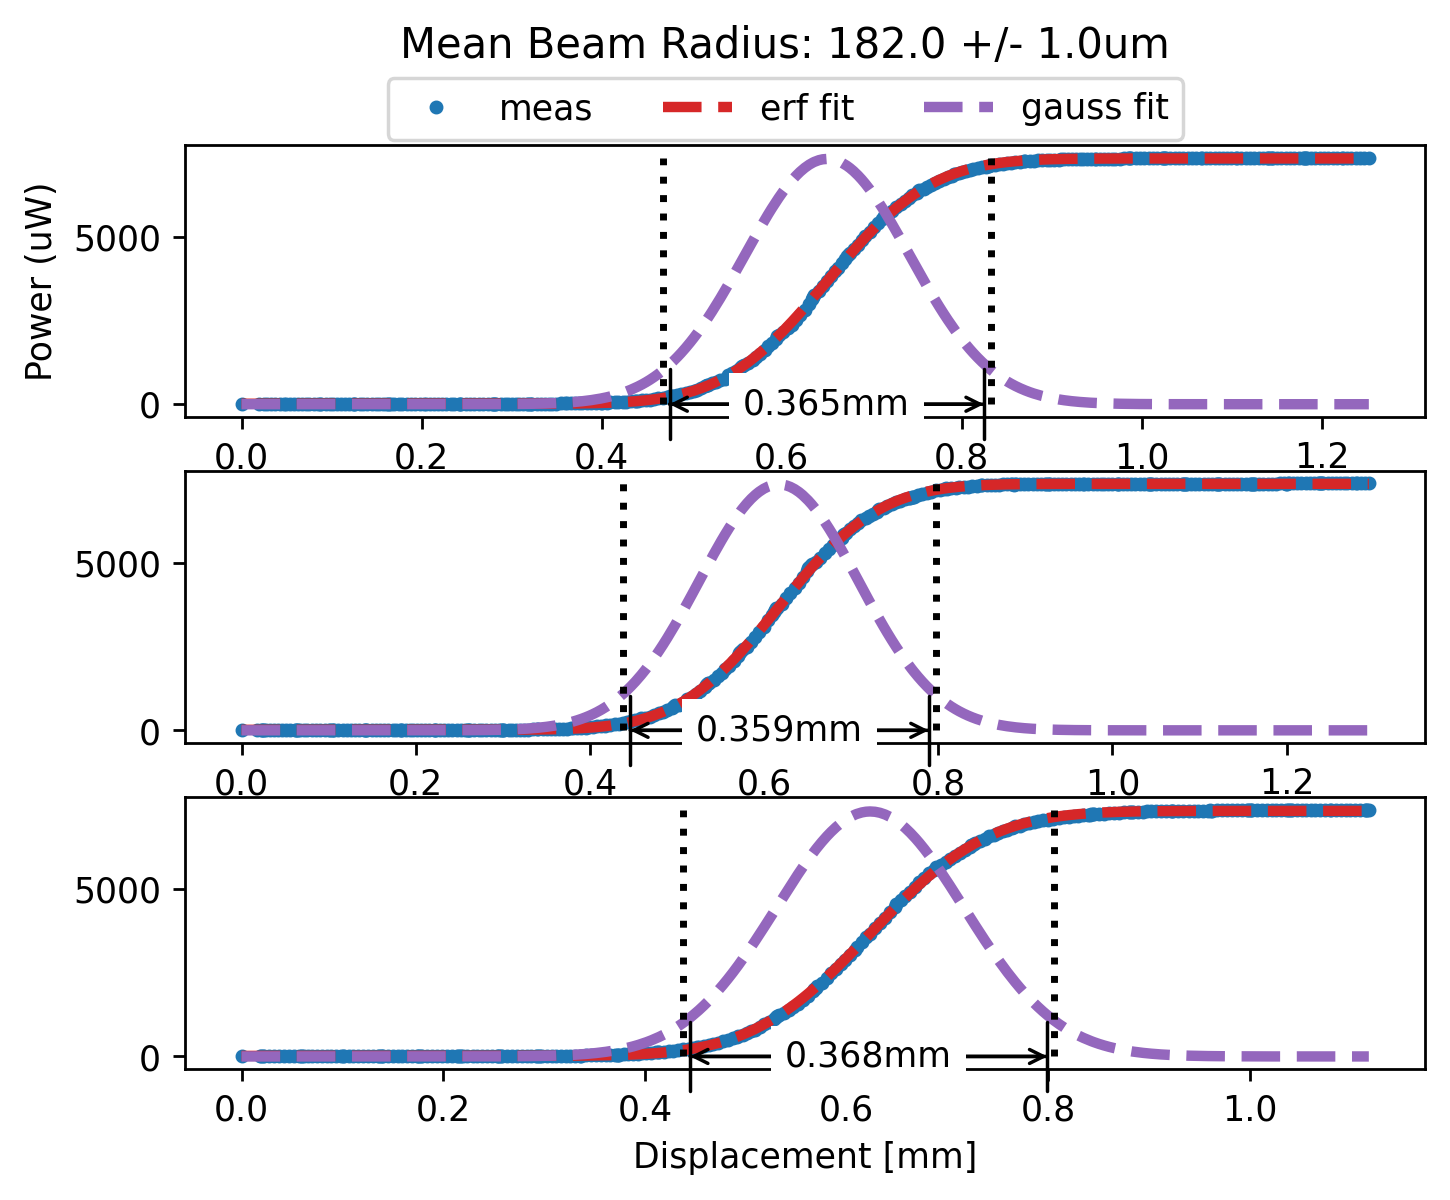

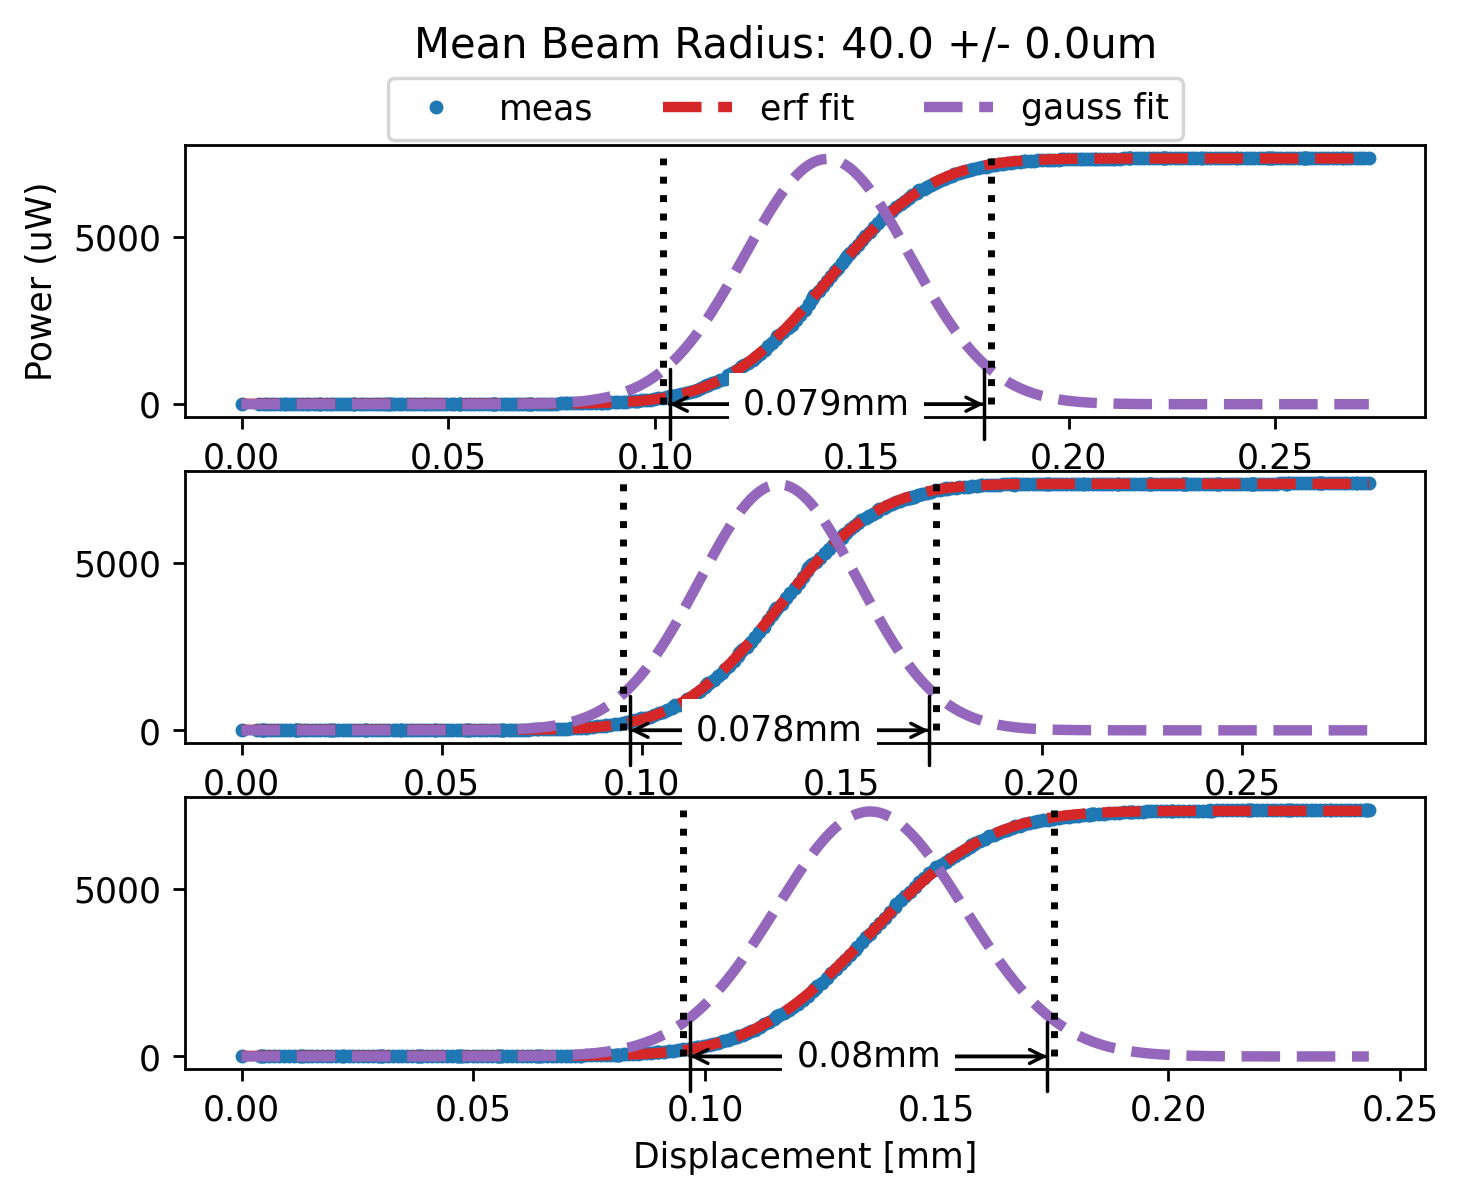

In [3]:
slow_v_data = [5.44824, 4.96972, 5.16894, 5.32715, 5.16797, 5.09668, 4.79297, 5.17773, 5.03418, 5.12597, 4.8164, 5.02929, 5.52637, 5.20703, 5.01758, 5.28613, 5.13086, 5.14453, 4.86523, 5.04883, 5.05566, 4.93652, 5.34277, 5.39453, 5.08789, 5.03808, 5.00683, 5.07031, 5.23437, 4.77929, 5.11719, 5.12402]
slow_v_df = pd.DataFrame({"times": slow_v_data})

slow_v = (slow_v_df
              .pipe(analyse.get_std_of_times)
              .pipe(analyse.get_velocity, 200)
              .pipe(analyse.get_velocity_std)
              .pipe(analyse.get_velocity_and_error)
               )
print("OG", slow_v)
slow_v_d = pd.read_csv("./Data/speed_1_data.txt", delimiter=",", header=1, usecols=[0,1])
v = analyse.get_average_velocity(slow_v_d)
print("NEW", v)
f1 = [ f"Data/knife-edge/single/1.csv" ]
f2 = [ f"Data/knife-edge/single/2{l}.csv" for l in "abc" ]

f3 = [ f"Data/knife-edge/single/3{l}.csv" for l in "abc" ]

plot_result(f3, slow_v)
plot_result(f3, v)